In [1]:
from IPython.display import HTML
file = open("../input/notebookassets/custom.css")
HTML("<style>"+file.read()+"</style>")

# Torch Multi-Model Trainer + Automatic Mixed Precision + Augmentations

This is the training pipeline that I've been using for a long time. Feel free to fork it, and make your changes!

<p>If you like my work, please consider giving an <strong style="font-family:Verdana;color:red;font-size:25px">Upvote</strong></p>

In [2]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import cv2
from tqdm.notebook import tqdm

from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

warnings.simplefilter("ignore")

In [4]:
class Config:
    CFG = {
        'img_size': 384,
        'tta': 3,
        'wd': 1e-6
    }

In [5]:
def plot_results(train_acc, valid_acc, train_loss, valid_loss, nb_epochs):
    epochs = [i for i in range(nb_epochs)]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    
    ax[0].plot(epochs, train_acc, 'go-', label='Training Accuracy')
    ax[0].plot(epochs, valid_acc, 'ro-', label='Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    
    ax[1].plot(epochs, train_loss, 'go-', label='Training Loss')
    ax[1].plot(epochs, valid_loss, 'ro-', label='Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    
    plt.show()

In [6]:
class Augments:
    """
    Contains Train, Validation and Testing Augments
    """
    train_augments = Compose([
            RandomResizedCrop(Config.CFG['img_size'], Config.CFG['img_size']),
            Transpose(p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ],p=1.)
    
    valid_augments = Compose([
            CenterCrop(Config.CFG['img_size'], Config.CFG['img_size'], p=1.),
            Resize(Config.CFG['img_size'], Config.CFG['img_size']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

In [7]:
class ResNextModel(nn.Module):
    """
    Model Class for ResNext Model Architectures
    """
    def __init__(self, num_classes=5, model_name='resnext50d_32x4d', pretrained=True):
        super(ResNextModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

class ResNetModel(nn.Module):
    """
    Model Class for ResNet Models
    """
    def __init__(self, num_classes=5, model_name='resnet18', pretrained=True):
        super(ResNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

class EfficientNetModel(nn.Module):
    """
    Model Class for EfficientNet Model
    """
    def __init__(self, num_classes=5, model_name='efficientnet_b5', pretrained=True):
        super(EfficientNetModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.model.classifier = nn.Linear(self.model.classifier.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x
    
class VITModel(nn.Module):
    """
    Model Class for VIT Model
    """
    def __init__(self, num_classes=5, model_name='vit_base_patch16_224', pretrained=True):
        super(VITModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
class LDCData(Dataset):
    def __init__(self, df, num_classes=5, is_train=True, augments=None, img_size=Config.CFG['img_size'], img_path="../input/cassava-leaf-disease-classification/train_images/"):
        super().__init__()
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.num_classes = num_classes
        self.is_train = is_train
        self.augments = augments
        self.img_size = img_size
        self.img_path = img_path
        
        # Add the Right Image Path
        self.df['image_id'] = self.df['image_id'].apply(lambda x: os.path.join(self.img_path, x))
    
    def __getitem__(self, idx):
        # Read the image, Resize, convert to RGB from BGR
        img = cv2.imread(self.df['image_id'][idx])
        img = img[:, :, ::-1]
        
        # Augments must be albumentations
        if self.augments:
            img = self.augments(image=img)['image']
        
        if self.is_train:
            label = self.df['label'][idx]
            return img, label
        
        return img
    
    def __len__(self):
        return len(self.df)

In [9]:
class Trainer:
    def __init__(self, train_dataloader, valid_dataloader, model, optimizer, loss_fn, val_loss_fn, scheduler, device="cuda:0", plot_results=True):
        """
        TODO: Implement the ROC-AUC Scheduler stuff
        """
        self.train = train_dataloader
        self.valid = valid_dataloader
        self.optim = optim
        self.loss_fn = loss_fn
        self.val_loss_fn = val_loss_fn
        self.scheduler = scheduler
        self.device = device
        self.plot_results = plot_results
    
    def train_one_cycle(self):
        """
        Runs one epoch of training, backpropagation, optimization and gets train accuracy
        """
        model.train()
        train_prog_bar = tqdm(self.train, total=len(self.train))

        all_train_labels = []
        all_train_preds = []
        
        running_loss = 0
        
        for xtrain, ytrain in train_prog_bar:
            xtrain = xtrain.to(device).float()
            ytrain = ytrain.to(device).long()
            
            with autocast():
                # Get predictions
                z = model(xtrain)

                # Training
                train_loss = self.loss_fn(z, ytrain)
                scaler.scale(train_loss).backward()
                
                scaler.step(self.optim)
                scaler.update()
                self.optim.zero_grad()

                # For averaging and reporting later
                running_loss += train_loss

                # Convert the predictions and corresponding labels to right form
                train_predictions = torch.argmax(z, 1).detach().cpu().numpy()
                train_labels = ytrain.detach().cpu().numpy()

                # Append current predictions and current labels to a list
                all_train_labels += [train_predictions]
                all_train_preds += [train_labels]

            # Show the current loss to the progress bar
            train_pbar_desc = f'loss: {train_loss.item():.4f}'
            train_prog_bar.set_description(desc=train_pbar_desc)
        
        # After all the batches are done, calculate the training accuracy
        all_train_preds = np.concatenate(all_train_preds)
        all_train_labels = np.concatenate(all_train_labels)
        
        train_acc = (all_train_preds == all_train_labels).mean()
        print(f"Training Accuracy: {train_acc:.4f}")
        
        # Now average the running loss over all batches and return
        train_running_loss = running_loss / len(self.train)
        
        # Free up memory
        del all_train_labels, all_train_preds, train_predictions, train_labels, xtrain, ytrain, z
        
        return (train_acc, train_running_loss)

    def valid_one_cycle(self):
        """
        Runs one epoch of prediction and validation accuracy calculation
        """        
        model.eval()
        
        valid_prog_bar = tqdm(self.valid, total=len(self.valid))
        
        with torch.no_grad():
            all_valid_labels = []
            all_valid_preds = []
            
            running_loss = 0
            
            for xval, yval in valid_prog_bar:
                xval = xval.to(device).float()
                yval = yval.to(device).long()
                
                val_z = model(xval)
                
                val_loss = self.val_loss_fn(val_z, yval)
                
                running_loss += val_loss.item()
                
                val_pred = torch.argmax(val_z, 1).detach().cpu().numpy()
                val_label = yval.detach().cpu().numpy()
                
                all_valid_labels += [val_label]
                all_valid_preds += [val_pred]
            
                # Show the current loss
                valid_pbar_desc = f"loss: {val_loss.item():.4f}"
                valid_prog_bar.set_description(desc=valid_pbar_desc)
            
            # Get the final loss
            final_loss_val = running_loss / len(self.valid)
            
            # Get Validation Accuracy
            all_valid_labels = np.concatenate(all_valid_labels)
            all_valid_preds = np.concatenate(all_valid_preds)
            
            val_accuracy = (all_valid_preds == all_valid_labels).mean()
            print(f"Validation Accuracy: {val_accuracy:.4f}")
            
            # Free up memory
            del all_valid_labels, all_valid_preds, val_label, val_pred, xval, yval, val_z
            
        return (val_accuracy, final_loss_val, model)

In [10]:
nb_epochs = 5
device = torch.device("cuda")

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_384-83fb41ba.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_384-83fb41ba.pth


-------------------- EPOCH: 0/5 --------------------



Training Accuracy: 0.8064



Validation Accuracy: 0.8565
Saving Model for this epoch...
-------------------- EPOCH: 1/5 --------------------



Training Accuracy: 0.8654



Validation Accuracy: 0.8699
Saving Model for this epoch...
-------------------- EPOCH: 2/5 --------------------



Training Accuracy: 0.8775



Validation Accuracy: 0.8783
Saving Model for this epoch...
-------------------- EPOCH: 3/5 --------------------



Training Accuracy: 0.8850



Validation Accuracy: 0.8794
Saving Model for this epoch...
-------------------- EPOCH: 4/5 --------------------



Training Accuracy: 0.8910



Validation Accuracy: 0.8860
Saving Model for this epoch...


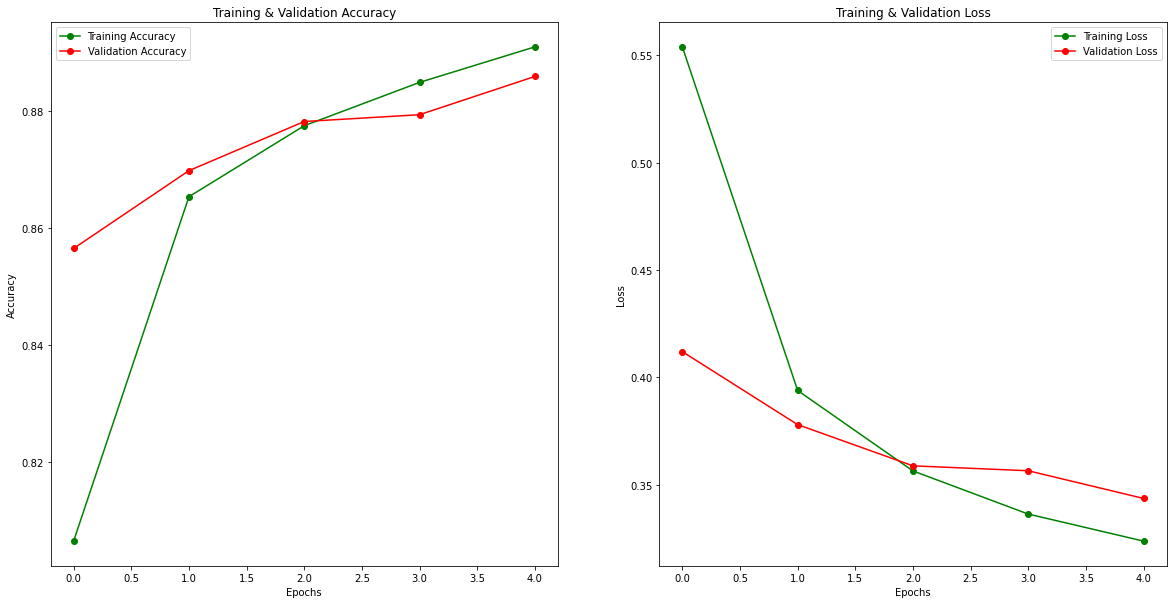

In [11]:
# Let's try individual fold modelling
fold = 0
train_fold = pd.read_csv(f"../input/cassava-5folds-data/fold_{fold}_train.csv")
valid_fold = pd.read_csv(f"../input/cassava-5folds-data/fold_{fold}_valid.csv")

train_set = LDCData(df=train_fold, augments=Augments.train_augments)
valid_set = LDCData(df=valid_fold, augments=Augments.valid_augments)

train = DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    pin_memory=False,
    drop_last=False,
    num_workers=8
)

valid = DataLoader(
    valid_set,
    batch_size=32,
    shuffle=False,
    pin_memory=False,
    num_workers=8
)

model = VITModel(num_classes=5, model_name='vit_base_patch16_384').to(device)
optim = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=Config.CFG['wd'])
loss_fn = nn.CrossEntropyLoss().to(device)
loss_fn_val = nn.CrossEntropyLoss().to(device)

trainer = Trainer(
    train_dataloader=train,
    valid_dataloader=valid,
    model=model,
    optimizer=optim,
    loss_fn=loss_fn,
    val_loss_fn=loss_fn_val,
    scheduler=None,
    device=device,
)

train_accs = []
valid_accs = []
train_losses = []
valid_losses = []

scaler = GradScaler()

for epoch in range(nb_epochs):
    print(f"{'-'*20} EPOCH: {epoch}/{nb_epochs} {'-'*20}")

    # Run one training epoch
    current_train_acc, current_train_loss = trainer.train_one_cycle()
    train_accs.append(current_train_acc)
    train_losses.append(current_train_loss)

    # Run one validation epoch
    current_val_acc, current_val_loss, op_model = trainer.valid_one_cycle()
    valid_accs.append(current_val_acc)
    valid_losses.append(current_val_loss)

    # Empty CUDA cache
    torch.cuda.empty_cache()
    
    # Save the model every epoch
    print(f"Saving Model for this epoch...")
    torch.save(op_model.state_dict(), f"vit_base_p16_384_fold_{fold}_model.pth")
    
del train_set, valid_set, train, valid, model, optim, loss_fn, loss_fn_val, trainer, scaler
torch.cuda.empty_cache()

plot_results(train_accs, valid_accs, train_losses, valid_losses, nb_epochs)